# G14_Encyclopedia_V1-V8_Visualization

## Describe
The challenge data for our group comes from the National Library of Scotland, which is the first eight editions of Encyclopedia Britannica. It was issued from 1768 to 1860 in 143 volumes. It was first published in Edinburgh from 1768 to 1771. The first edition consists of three volumes. The encyclopedia is getting bigger and bigger: the second edition has 10 volumes, and by the fourth edition, it has expanded to 20 volumes. We downloaded the "text only" file, which includes 1 plain text readme file; 1 CSV inventory file; and 195 plain text files.
+ The general type of my data is all the words in the encyclopedia. I saw through the CSV inventory file: The first edition has 3 volumes, the second edition has 10 volumes, and the third edition has two versions. After contacting the data owner, I deleted the redundant duplicate volumes according to the prompts and the third edition is 4 roll.
+ Its scale is huge and complicated. First, according to the CSV directory file, it can be seen that it has a total of 195 volumes. Secondly, after opening the txt text file, it is found that the text comes from OCR scanning and is not cleaned up. This also means that it is completely unstructured text data.
+ The types of our data include text, numbers, and symbols, and fields include titles, text, notes, quotations, mathematical or chemical formulas, etc.
+ These different types of fields are all explanatory in nature, and they are used to describe or illustrate a certain topic.
+ We considered here to analyze only the text, so the symbols and numbers are cleaned up in the code below.
+ The data owner is the National Library of Scotland. We plan to extract all the topics in the encyclopedia, through the distribution of the entries of the corresponding topics in each version, to understand its changing trends, from a macro perspective to understand the theme changes of the eight editions of the encyclopedia, and then from the micro Explore the reasons for the changes from the perspective, and finally realize the visual display, showing the audience the changes in the theme content that the United Kingdom has begun to see the world sees.

In [3]:
import os
import glob
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid",palette=sns.color_palette("Set2"))

import re
import string  
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize,pos_tag
from nltk.stem import WordNetLemmatizer,lancaster
import spacy

import stylecloud
from PIL import Image as pil_image


pd.set_option("display.max_colwidth",1000)

import warnings
warnings.filterwarnings("ignore")

### Preparation before Expolre

1. Installation instructions for non-standard software packages:
+ [Installing NLTK](https://www.nltk.org/install.html) & [Installing NLTK Data](https://www.nltk.org/data.html)  ***Install code:*** “pip install --user -U nltk” & “nltk.download('all')”
+ [Install spaCy](https://spacy.io/usage) & [en_core_web_lg](https://spacy.io/models/en#en_core_web_lg)  ***Install code:*** "pip install -U pip setuptools wheel" & "pip install -U spacy" & “conda install -c conda-forge spacy-model-en_core_web_lg”
+ [Install wordcloud](https://pypi.org/project/wordcloud/) & [stylecloud](https://pypi.org/project/stylecloud/) ***Install code:*** "conda install -c conda-forge wordcloud" & "pip install stylecloud"
2. Description of text data storage method (here you need to take out different versions of .txt files and put them in the corresponding folders):
+ ./Encyclopedia Britannica V1-V8 *(Folder of all .txt files in version 1-8)*
+ ./G14_Encyclopedia_V1-V8_Visualization


# 1. Preliminary data cleaning
Since the provided text data is scanned by OCR, it is very noisy, and one sentence or one word may be disconnected. So the first thing I did was to restore it to the original text paragraph.

In [4]:
files_list=glob.glob(os.path.join("Encyclopedia Britannica V1-V8","Version 1","*.txt"))
files_list=sorted(files_list)
files_list

['Encyclopedia Britannica V1-V8/Version 1/144133901.txt',
 'Encyclopedia Britannica V1-V8/Version 1/144133902.txt',
 'Encyclopedia Britannica V1-V8/Version 1/144133903.txt']

In [5]:
files_list[0].split(os.sep)

['Encyclopedia Britannica V1-V8', 'Version 1', '144133901.txt']

In [6]:

def clean_raw_lines(line):
    if line.endswith("-\n"):
        line=line.replace("-\n","")
    elif line.endswith("¬\n"):
        line=line.replace("¬\n","")
    elif line.endswith(".\n"):
        line=line
    else:
        line=line.replace("\n"," ")
    return line
    
def read_txt_files(files_list):
    file_content_list=[]
    for file in files_list:
        
        # Read a txt file and put the read content into the list
        with open(file,encoding="utf-8") as f:            
            lines=f.readlines()
        lines=[clean_raw_lines(line) for line in lines]
        text="".join(lines)
        file_content_list.extend(text.split("\n"))
            
    # Combine the various text contents in the list
    return file_content_list
    


In [7]:
files_content=read_txt_files(files_list)

df_files_content=pd.DataFrame([files_content]).T
df_files_content.columns=["text"]

In [8]:
df_files_content[200:210]

,text
200,"ABARTICULATION, in anatomy, a fpeeies of articulation which is now termed diarthrofts. See Anatomy, Part I. and Diarthrofs."
201,"ABAS, a weight ufed in Perfia for weighing pearls. It is l-8th lefs than the European carat. *' ABB ABASCIA, the country of the Alcas. SccAlcas."
202,"ABAISED, Abaijfe, in heraldry, an epithet applied to ' the wings ofe&gies, &c. when the tip looks downwards to the point of the (liield, or. when the wings are (hut; the natural way of bearing them being extended."
203,"ABASING, in the fea-language, fignifies the fame as driking."
204,"ABASSI, or Abassas, a filver coin current in Perfia,."
205,"equivalent in value to a French livre, or tenpence halfpenny Sterling. It took its name from Schaw Abas II."
206,"king of Perfia, under whom it was-druck."
207,"ABATAMENTUM, in law, is an entry to lands by interpofition, i. e. when a perfon dies feized, and another who has no right enters before the heir."
208,"ABATE, from abatre, to dedroy ; a term ufed by the writers of the common law, both in an a<5tive and neutral fenfe ; as, to abate a cadle, is to dedroy or beat it down.; to abate a writ, is, by fome exception to render it null and void."
209,"Abate, in the manage, implies the performance of any downward motion properly. Hence a horfe is faid ta abate, or take down his curvets, when he puts both his hind-legs to the ground at once, and obferves the fame exaftnefs in all the times."


## 1.1 Draft entry merging standards
    # If a sentence starts with several consecutive capital letters and then a comma, then it is considered the beginning of an entry；
    # If a sentence does not meet this condition, then it will be considered that the sentence should belong to the previous entry.

![sample](sample.png)

In [9]:
# Clean up text data through regular expressions

sample1="ABASSI, or Abassas, a filver coin current in Perfia"
re.match(r"[A-Z]+,",sample1).group()

'ABASSI,'

In [10]:
# If this pattern cannot be matched, the result will be None
sample2="Abate, in the manage, implies the performance of any downward motion properly."
re.match(r"[A-Z]+,",sample2)

In [11]:
type(re.match(r"[A-Z]+,",sample2))

NoneType

In [12]:
print(re.match(r"[A-Z]+,",sample1) is None)
print(re.match(r"[A-Z]+,",sample2) is None)

False
True


In [13]:
# The first half of each chapter of the encyclopedia is an Overall view instead of an entry, so I initially defined it as ""
word=""
word_dict={}
whole_sent=""
for sent in df_files_content["text"]:
    # If a sentence does not match the entry, it will be appended to the previous entry
    res=re.match(r"[A-Z]+,",sent)
    if res is None:
        whole_sent+=sent
    else:
        # If a sentence matches the entry, save the previous entry and start a new entry
        word_dict[word]=whole_sent            
        word=res.group().strip(",")
        whole_sent=sent.replace(word+",","")

# Add the last entry
word_dict[word]=whole_sent

In [14]:
# The first half of each chapter of the encyclopedia is that Overall view is not an entry, I initially defined it as ""
word=""
word_dict={}
whole_sent=""
for sent in df_files_content["text"]:
    # If a sentence does not match the entry, it will be appended to the previous entry
    res=re.match(r"[A-Z]+,",sent)
    if res is None:
        whole_sent+=sent
    else:
        # If a sentence matches the entry, save the previous entry and start a new word
        word_dict[word]=whole_sent            
        word=res.group().strip(",")
        whole_sent=sent.replace(word+",","")

# Add the last entry
word_dict[word]=whole_sent

In [52]:
# This is all the extracted entries

word_dict.keys()

dict_keys(['', 'SCO', 'AABAM', 'AADE', 'AAHUS', 'AAM', 'AAR', 'AARSEO', 'AATTER', 'AB', 'ABACATUAIA', 'ABACH', 'ABACO', 'ABACOT', 'ABACTORES', 'ABACTUS', 'ABACUS', 'ABADAN', 'ABADDON', 'ABADIR', 'ABACRE', 'ABAFT', 'ABAI', 'ABANBO', 'ABANCAI', 'ABANO', 'ABAPTISTON', 'ABARCA', 'ABARTICULATION', 'ABAS', 'ABAISED', 'ABASING', 'ABASSI', 'ABATAMENTUM', 'ABATE', 'ABATEMENT', 'ABATIS', 'ABAVO', 'ABB', 'ABBA', 'ABBEFORD', 'ABBESS', 'ABBEVILLE', 'ABBEY', 'ABBOT', 'ABBREVIATION', 'ABBREVIATOR', 'ABBREVOIR', 'ABBUTTALS', 'ABCASSES', 'ABCDARIA', 'ABCDARY', 'ABDALS', 'ABDELAVI', 'ABDEST', 'ABDICATION', 'ABDOMEN', 'ABDUCTION', 'ABDUCTOR', 'ABELIANS', 'ABELMOSCH', 'ABENSBURG', 'ABERBROTHOCK', 'ABERDEEN', 'ABERGAVENY', 'ABERMURDER', 'ABERRATION', 'ABERYSWITH', 'ABESTA', 'ABETTOR', 'ABEVACUATION', 'ABEX', 'ABEYANCE', 'ABHEL', 'ABIB', 'ABIES', 'ABILITY', 'ABINGDON', 'ABISHERING', 'ABIT', 'ABJURATION', 'ABLAC', 'ABLACTATION', 'ABLACQUEATION', 'ABLATIVE', 'ABLAY', 'ABLEGMINA', 'ABLET', 'ABLUENTS', 'ABLUTIO

In [16]:
pd.DataFrame([word_dict]).T

,0
,"i ! $* i $: iu^b ' n*s-f7^'v L i A j J ^ /^^W/ ; h:;^’ J - }r-r£c9'&} ""*— "" ..^4-—>, 'I ■ .,/.■ -,... v V *• C*?>7 y <rw /U^v UJ~L ^ (txk^L j 1rvt*Xitj $/i*4j/cJysx*£>Xb<. f^oLZ^^c^. % 'bvC JJ.' }v*c CclU^K <77t .yy*t4**2^t*-C{+r ^tXCe^vK &v»w 8/y: t^cCv-yt^yA. *-? ^v. •^GL* ftc*frt * U^>. ‘ ** a^yUf^yX ^ }tA£. yylrrCj? yu>t f\ ^^2! ENCYCLOPEDIA BRITANNICA.VOLUME the FIRST.**■* ' ,T S :u -I >;j .1 M U a C V' .A ARTS and SCIENCES, COVI PILED UPON A NEW PLAN.IN WHICH The diferent Sciences and Arts are dioefted into "" O diflinct Treatifes or Syitems; AND . The \irious Technic a lTerms, <&c. are explained as they occur in the order of the Alphabet.ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERPLATES.fry a Society of GENTLEMEN in Scotland.IN THREE VOLUME S.VOL. I.EDINBURGH: Printed for A. Bell and C. Macearquhar; Aid fold by C o l i n M a cf a r q.u h a r, at his Printing-office, N.coifon-HreeL \l965r."
SCO,"PREFACE UTILITY ought to be the principal intention of every publication.Wherever this intention does not plainly appear, neither the books nor their authors have the finalleft claim to the approbation of mankind.To diffufe the knowledge of Science, is the profefled defign of the following work. What methods, it may be alked, have the compilers employed to accomplilh this delign ? Not to mention original articles, they have had recourle to the belt books upon almoft every lubjedt, extracted the ufefiil parts, and rejected whatever appeared trifling or lefs interefting. Inftead of difinembering the Sciences, by attempting to treat them intelligibly under a multitude of technical terms, they have digefted the principles of every Icience in the form of lyftems or diftindl treatifes, and explained the terms as they occur in the order of the alphabet, with references to the Iciences to which they belong.As this plan differs from that of all the Dictionaries of Arts and Sciences hitherto..."
AABAM,"a term, among alchemifts, for lead, AACH, the name of a town and river in Swabia. It is alfo a name fometimes given toAix-la-chapelle."
AADE,"the name of two rivers, one in the country of the Grifons in Switzerland, and the other in Dutch Brabant."
AAHUS,a fmall town and diftrift in Weftphalia.
...,...
ZUTPHEN,"a city of a county of the fame name, in Gelderland, fituated on the river Ylfel, fixteen miles northeal! of Arnheim : E. long. 6°, N. lat. 52° 15'."
ZUYDERSEE,"a great bay of the German ocean, which lies in the middle of the United provinces, having the illands of Texel, Flie, and Schelling, at the entrance of it, on the ntirth ; the provinces of Friefland, Overylfel, and Gelderland, on the eaft ; Utrecht, and part of Holland, on the fouth ; and another part of Holland on the weft. The chief town is Amfterdam."
ZWEIBRUGGEN,"a county of the palatinate of the.Rhme, in Germany, fubjeft to the duke of Deuxponts.ZYGAlNA, in ichthyology. See Sq_alvs."
ZYGOMA,in anatomy. See Anatomy p. 152.


## 1.2 Function definition
Given a version of the path, clean out the entry content of that version

In [17]:
def clean_raw_lines(line):
    if line.endswith("-\n"):
        line=line.replace("-\n","")
    elif line.endswith("¬\n"):
        line=line.replace("¬\n","")
    elif line.endswith(".\n"):
        line=line
    else:
        line=line.replace("\n"," ")
    return line
    
def read_txt_files(files_list):
    file_content_list=[]
    for file in files_list:
        print("\t - {}".format(file))
        
        # Read a txt file and put the read content into the list
        with open(file,encoding="utf-8") as f:            
            lines=f.readlines()
        lines=[clean_raw_lines(line) for line in lines]
        text="".join(lines)
        file_content_list.extend(text.split("\n"))
            
    # Combine the various text contents in the list
    return file_content_list

def more_clean(df_sentence):
    word=""
    word_dict={}
    whole_sent=""
    for sent in df_sentence["text"]:
        # If a sentence does not match the entry, it will be appended to the previous entry
        res=re.match(r"[A-Z]+,",sent)
        if res is None:
            whole_sent+=sent
        else:
            # If a sentence matches the entry, save the previous entry and start a new entry
            word_dict[word]=whole_sent            
            word=res.group().strip(",")
            whole_sent=sent.replace(word+",","")

    # Add the last entry
    word_dict[word]=whole_sent
    df=pd.DataFrame([word_dict]).T
    df.columns=["text"]
    return df

def clean_all_in_one(version_num):
    # What txt found
    files_list=glob.glob(os.path.join("Encyclopedia Britannica V1-V8","Version {}".format(version_num),"*.txt"))
    print("Reading: {}".format(os.path.join("Encyclopedia Britannica V1-V8","Version {}".format(version_num))))
    files_list=sorted(files_list)

    # Preliminarily cleaned out paragraphs
    files_content=read_txt_files(files_list)
    df_sentence=pd.DataFrame([files_content]).T
    df_sentence.columns=["text"]
    
    # Further clean up entries
    df_encyclopedia=more_clean(df_sentence)
    return df_encyclopedia
    

## 1.2.1 Read all versions and clean

In [18]:
# Read all versions

df_encyclopedia_list=[]
for i in range(1,9):
    df_encyclopedia=clean_all_in_one(i)
    df_encyclopedia["version"]=i
    df_encyclopedia_list.append(df_encyclopedia)
    
df_encyclopedia_all=pd.concat(df_encyclopedia_list)

Reading: Encyclopedia Britannica V1-V8/Version 1
	 - Encyclopedia Britannica V1-V8/Version 1/144133901.txt
	 - Encyclopedia Britannica V1-V8/Version 1/144133902.txt
	 - Encyclopedia Britannica V1-V8/Version 1/144133903.txt
Reading: Encyclopedia Britannica V1-V8/Version 2
	 - Encyclopedia Britannica V1-V8/Version 2/144850370.txt
	 - Encyclopedia Britannica V1-V8/Version 2/144850373.txt
	 - Encyclopedia Britannica V1-V8/Version 2/144850374.txt
	 - Encyclopedia Britannica V1-V8/Version 2/144850375.txt
	 - Encyclopedia Britannica V1-V8/Version 2/144850376.txt
	 - Encyclopedia Britannica V1-V8/Version 2/144850377.txt
	 - Encyclopedia Britannica V1-V8/Version 2/144850378.txt
	 - Encyclopedia Britannica V1-V8/Version 2/144850379.txt
	 - Encyclopedia Britannica V1-V8/Version 2/190273289.txt
	 - Encyclopedia Britannica V1-V8/Version 2/190273290.txt
Reading: Encyclopedia Britannica V1-V8/Version 3
	 - Encyclopedia Britannica V1-V8/Version 3/149977338.txt
	 - Encyclopedia Britannica V1-V8/Version

	 - Encyclopedia Britannica V1-V8/Version 7/193322689.txt
	 - Encyclopedia Britannica V1-V8/Version 7/193322690.txt
	 - Encyclopedia Britannica V1-V8/Version 7/193469090.txt
	 - Encyclopedia Britannica V1-V8/Version 7/193469091.txt
	 - Encyclopedia Britannica V1-V8/Version 7/193469092.txt
	 - Encyclopedia Britannica V1-V8/Version 7/193638940.txt
	 - Encyclopedia Britannica V1-V8/Version 7/193696083.txt
	 - Encyclopedia Britannica V1-V8/Version 7/193696084.txt
	 - Encyclopedia Britannica V1-V8/Version 7/193819043.txt
	 - Encyclopedia Britannica V1-V8/Version 7/193819044.txt
	 - Encyclopedia Britannica V1-V8/Version 7/193819045.txt
	 - Encyclopedia Britannica V1-V8/Version 7/193913444.txt
	 - Encyclopedia Britannica V1-V8/Version 7/194474782.txt
Reading: Encyclopedia Britannica V1-V8/Version 8
	 - Encyclopedia Britannica V1-V8/Version 8/192984260.txt
	 - Encyclopedia Britannica V1-V8/Version 8/193108324.txt
	 - Encyclopedia Britannica V1-V8/Version 8/193108325.txt
	 - Encyclopedia Britan

In [19]:
df_encyclopedia_all.iloc[100:110,:]

,text,version
ABRA,"a filver coin of Poland, in value nearly equivalent to an Englifli Hulling.",1
ABRACADABRA,"a magical word or fpell, which being written as many times as the word contains letters, and omitting the lad letter of the former every time, was, in the ages of ignorance and fuperdition, vvyrn about the neck, as an antidote againd agues andfeveral other difeaies ABRAHAM’r balm, in botany, See Cannabis.",1
ABRAHAMITES,an order of monks exterminated - for idolatry by Theophilus in the ninth century. Alfo the name of another fedt of heretics who had adopted the errors of Paulus. See Paulicians.,1
ABRAMIS,"an obfclete name for the filh cyprinus. See Cyprinus, B Abrasa, A B R (6 ABRASA, in furgery, ulcers, where the Ikin is fo tender and lax as to render them fubjeft to abrafion.",1
ABRASION,"in medicine, the corroding of any part by acrid humours or medicines.",1
ABRAUM,"an obfolete name of a certain fpecies of clay, called by fome authors Adamic earth, on account of its red colour.",1
ABRASAX,"or Abraxas, a myftical term found in the ancient theology and philofophy of Balilides’s followers.",1
ABRAX,"an antique (tone with the word abraxas engraved on it. They are of various fizes, and molt of them as old as the third century.",1
ABREAST,"a fea-term. In an attack, purfuit, .or retreat at fea, the fquadrons or divilions of a fleet are often obliged to vary their difpofitions, and at the fame time obferve a proper regularity, by failing in right or curved lines: when they fail at a proper diftance from each other, and are all equally forward, they are then faid to have formed the line abreajl.ABRENUNCIATION See Renunciation.",1
ABRIDGEMENT,"in literature, a term fignifying the redudtion of a book into a fmaller compafs. — The art of conveying much fentiment in few words, is the happieft talent an author can be poflefled of. This talent b peculiarly neceflary in the prefent ftate of literature ; for many writers have acquired the dexterity of fpreading a few tritical thoughts over feveral hundred pages. When an author hits upon a thought that pleafes him, he is apt to dwell upon it, to view it in different lights, to force it in improperly, or upon the flightefl: relations. Though this may be pleafant to the writer, it tires and vexes the reader.There is another great fource of diffufion in compofition. It is a capital object with an author, whatever be the fubjedt, to give vent to all his beft thoughts.When he finds a proper place for any of them, he is peculiarly happy. But, rather than facrifice a thought he is fond of, he forces it in by way of digreflion, or fuperfluous illuftration. If none of thefe expedients a...",1


In [20]:
df_encyclopedia_all.shape

(113196, 2)

# 2. Further data cleaning

This is mainly to remove non-letter words in text

In [21]:
stop_words=stopwords.words('english')
            
            
def clean_text(text):
   
    # Remove all non-English letters directly
    patten=r'[^a-z]'
    text=re.sub(patten,' ',text.lower())
    
    # Replace multiple consecutive spaces with 1 space
    text_list = re.sub(r'\s+', ' ', text).split()
    
    # Remove stop words
    text_list=[word for word in text_list if ((word not in stop_words) and len(word)>3)]
    return " ".join(text_list)


df_encyclopedia_all["text_clean"]=df_encyclopedia_all["text"].apply(clean_text)

df_encyclopedia_all.iloc[100:110,:]

,text,version,text_clean
ABRA,"a filver coin of Poland, in value nearly equivalent to an Englifli Hulling.",1,filver coin poland value nearly equivalent englifli hulling
ABRACADABRA,"a magical word or fpell, which being written as many times as the word contains letters, and omitting the lad letter of the former every time, was, in the ages of ignorance and fuperdition, vvyrn about the neck, as an antidote againd agues andfeveral other difeaies ABRAHAM’r balm, in botany, See Cannabis.",1,magical word fpell written many times word contains letters omitting letter former every time ages ignorance fuperdition vvyrn neck antidote againd agues andfeveral difeaies abraham balm botany cannabis
ABRAHAMITES,an order of monks exterminated - for idolatry by Theophilus in the ninth century. Alfo the name of another fedt of heretics who had adopted the errors of Paulus. See Paulicians.,1,order monks exterminated idolatry theophilus ninth century alfo name another fedt heretics adopted errors paulus paulicians
ABRAMIS,"an obfclete name for the filh cyprinus. See Cyprinus, B Abrasa, A B R (6 ABRASA, in furgery, ulcers, where the Ikin is fo tender and lax as to render them fubjeft to abrafion.",1,obfclete name filh cyprinus cyprinus abrasa abrasa furgery ulcers ikin tender render fubjeft abrafion
ABRASION,"in medicine, the corroding of any part by acrid humours or medicines.",1,medicine corroding part acrid humours medicines
ABRAUM,"an obfolete name of a certain fpecies of clay, called by fome authors Adamic earth, on account of its red colour.",1,obfolete name certain fpecies clay called fome authors adamic earth account colour
ABRASAX,"or Abraxas, a myftical term found in the ancient theology and philofophy of Balilides’s followers.",1,abraxas myftical term found ancient theology philofophy balilides followers
ABRAX,"an antique (tone with the word abraxas engraved on it. They are of various fizes, and molt of them as old as the third century.",1,antique tone word abraxas engraved various fizes molt third century
ABREAST,"a fea-term. In an attack, purfuit, .or retreat at fea, the fquadrons or divilions of a fleet are often obliged to vary their difpofitions, and at the fame time obferve a proper regularity, by failing in right or curved lines: when they fail at a proper diftance from each other, and are all equally forward, they are then faid to have formed the line abreajl.ABRENUNCIATION See Renunciation.",1,term attack purfuit retreat fquadrons divilions fleet often obliged vary difpofitions fame time obferve proper regularity failing right curved lines fail proper diftance equally forward faid formed line abreajl abrenunciation renunciation
ABRIDGEMENT,"in literature, a term fignifying the redudtion of a book into a fmaller compafs. — The art of conveying much fentiment in few words, is the happieft talent an author can be poflefled of. This talent b peculiarly neceflary in the prefent ftate of literature ; for many writers have acquired the dexterity of fpreading a few tritical thoughts over feveral hundred pages. When an author hits upon a thought that pleafes him, he is apt to dwell upon it, to view it in different lights, to force it in improperly, or upon the flightefl: relations. Though this may be pleafant to the writer, it tires and vexes the reader.There is another great fource of diffufion in compofition. It is a capital object with an author, whatever be the fubjedt, to give vent to all his beft thoughts.When he finds a proper place for any of them, he is peculiarly happy. But, rather than facrifice a thought he is fond of, he forces it in by way of digreflion, or fuperfluous illuftration. If none of thefe expedients a...",1,literature term fignifying redudtion book fmaller compafs conveying much fentiment words happieft talent author poflefled talent peculiarly neceflary prefent ftate literature many writers acquired dexterity fpreading tritical thoughts feveral hundred pages author hits upon thought pleafes dwell upon view di

# 3. LDA model

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english',
                        min_df=20,
                        max_df=0.1,                      
                        max_features=5000)
X = count.fit_transform(df_encyclopedia_all['text_clean'].values)

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                random_state=123)

X_topics = lda.fit_transform(X)

## 3.1 Extract representative vocabulary for each topic

+ Here are the top 20 important vocabularies for each topic

In [24]:
n_top_words = 20
feature_names = count.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic 1:
equal motion line point velocity force centre angle axis weight plane feet lines distance diameter parallel points circle inches greater
Topic 2:
muft fide fmall feet lefs furface diftance becaufe cafe fecond iron fquare earth piece placed hand quantity half round inches
Topic 3:
small surface heat used iron acid glass light colour state matter quantity process substance temperature produced white species size placed
Topic 4:
army emperor prince enemy troops kingdom empire battle obliged government rome arms duke roman peace romans power defeated military reign
Topic 5:
himfelf perfon faid againft themfelves lord houfe perfons language mind prefent laft court things power words world hiftory whofe father
Topic 6:
earth colour moon light acid rays plants white colours glafs leaves latitude quantity flowers method index botany heat fait fixed
Topic 7:
fometimes blood fmall quantity proper muft frequently animal trees plants ground cold animals food difeafe lefs foon medicine fho

In [25]:

for i in range(10):
    print('\nTopic{}:'.format(i+1))
    topic = X_topics[:, i].argsort()[::-1]

    for iter_idx, text_idx in enumerate(topic[:3]): 
        print('\n\t sample#{}:'.format(iter_idx + 1),end=" ")
        print(df_encyclopedia_all['text'][text_idx][:200], '...')  
        
    print('='*120)


Topic1:

	 sample#1:  PQ with a third plane FG, are parallel.For if the lines EF, GH, situated in the same plane, are not parallel, they must meet if produced ; therefore the planes MN, PQ, in which they are, must also me ...

	 sample#2:  a genus of plants belonging to the triandria class. See Botany Index.ROTANG. See Calamus.T I O N.require a previous acquaintance with certain general propositions of rotatory motion.It is chiefly wit ...

	 sample#3:  DEF have A D the angle A equal A.to the angle D, the / side AB equal to / DE, and the side / \ AC equal to DF ; / the triangles shall / \ be equal. For if the B c triangle ABC be applied to the trian ...

Topic2:

	 sample#1:  the art of carting and working lead, and ufing it in building.As this metal melts foon and with little heat, it is eafy to cart; it into figures of any kind, by running it into moulds of brafs, clay, ...

	 sample#2:  the art of calling and working lead, and ufing it in building.As this metal melts foon and with 

In [26]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 20), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.95, hspace=0.2)
    plt.show()   


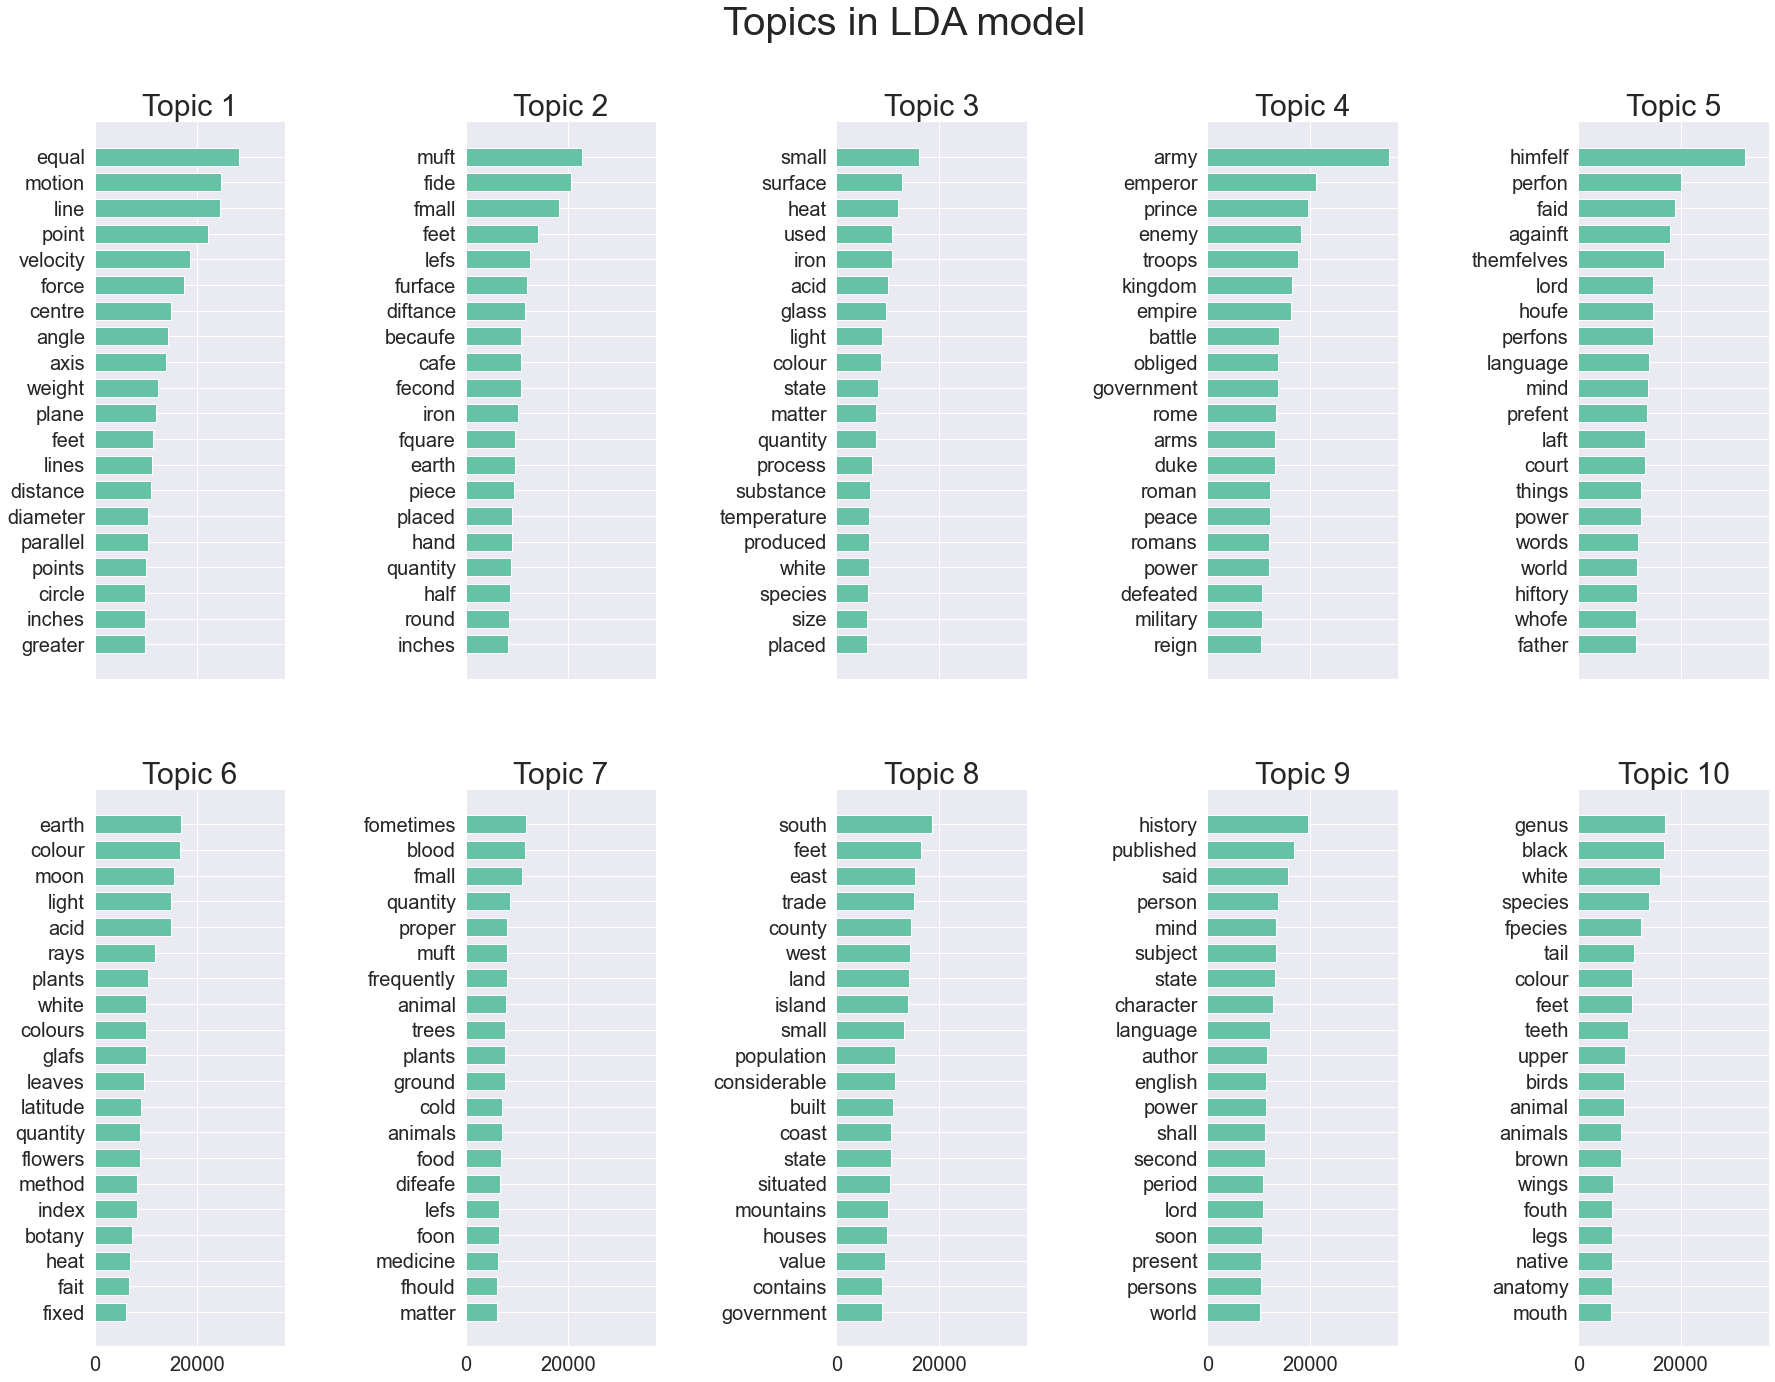

In [27]:
# The following are the Top 10 important vocabularies for each topic
%matplotlib inline

plot_top_words(model=lda, feature_names=feature_names, n_top_words=20, title='Topics in LDA model')

# 4. Count the distribution of entries for each topic by version

In [28]:
# Mark the topic to which each entry belongs
# I take the topic with the highest probability as the topic to which the entry belongs

df_encyclopedia_all["topic"]=X_topics.argmax(axis=1)

In [29]:
# Count the number of entries for each topic in the same version

df_version_topic=df_encyclopedia_all.pivot_table(index="version",columns="topic",values="text",aggfunc="count")
df_version_topic

topic,0,1,2,3,4,5,6,7,8,9
version,,,,,,,,,,
1,494,1271,31,658,2781,1022,1160,473,73,4130
2,325,1569,28,910,4600,775,1724,395,60,2312
3,413,1936,28,1191,6427,1220,1947,513,56,2595
4,429,1957,30,1155,6350,1483,1493,580,66,2444
5,413,1988,30,1152,6337,1414,1503,580,70,2465
6,964,94,1543,1136,221,1041,296,3804,5943,1342
7,638,60,788,724,128,138,124,6136,4644,373
8,383,21,549,488,53,69,42,4204,3934,260


In [30]:
# In the same version, calculate the proportion of the number of entries for each topic

df_version_topic.div(df_version_topic.sum(axis=1),axis=0)

topic,0,1,2,3,4,5,6,7,8,9
version,,,,,,,,,,
1,0.040850,0.105102,0.002563,0.054412,0.229968,0.084512,0.095923,0.039114,0.006037,0.341520
2,0.025595,0.123563,0.002205,0.071665,0.362262,0.061033,0.135769,0.031107,0.004725,0.182076
3,0.025297,0.118584,0.001715,0.072951,0.393667,0.074727,0.119258,0.031422,0.003430,0.158949
4,0.026834,0.122412,0.001877,0.072246,0.397198,0.092763,0.093388,0.036279,0.004128,0.152874
5,0.025890,0.124624,0.001881,0.072217,0.397254,0.088641,0.094220,0.036359,0.004388,0.154526
6,0.058838,0.005737,0.094177,0.069336,0.013489,0.063538,0.018066,0.232178,0.362732,0.081909
7,0.046390,0.004363,0.057297,0.052643,0.009307,0.010034,0.009016,0.446157,0.337672,0.027121
8,0.038289,0.002099,0.054884,0.048785,0.005298,0.006898,0.004199,0.420274,0.393282,0.025992


Text(0.5, 1.0, 'Frequency Distribution of Each Topic by Version')

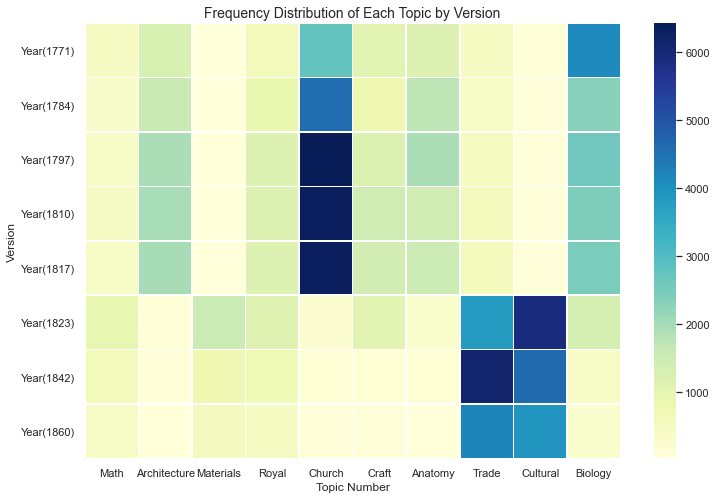

In [31]:
# Name the theme and visualize it
topic_labels=["Math","Architecture","Materials","Royal","Church","Craft","Anatomy","Trade","Cultural","Biology"]

plt.figure(figsize=(12,8))
sns.heatmap(df_version_topic, cmap="YlGnBu",linewidths=.5)

plt.xlabel("Topic Number",fontsize=12)
plt.xticks([x+0.5 for x in range(10)],topic_labels)

plt.ylabel("Version",fontsize=12)
plt.yticks([x+0.5 for x in range(8)],
           ['Year(1771)','Year(1784)','Year(1797)','Year(1810)','Year(1817)','Year(1823)','Year(1842)','Year(1860)'],
           rotation=0)

plt.title("Frequency Distribution of Each Topic by Version",fontsize=14)

Text(0.5, 0, 'Topic Percentage')

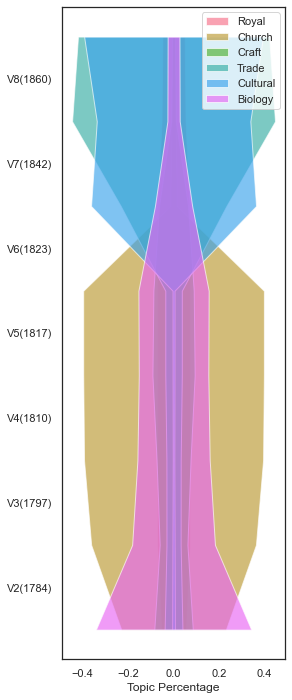

In [33]:
sns.set_theme(style="white",palette=sns.color_palette("husl"))

topic_labels=["Math","Architecture","Materials","Royal","Church","Craft","Anatomy","Trade","Cultural","Biology"]

df_topic_pct=df_version_topic.div(df_version_topic.sum(axis=1),axis=0)
plt.figure(figsize=(4,12))
plt.yticks([x+0.5 for x in range(8)],
           ['V1(1771)','V2(1784)','V3(1797)','V4(1810)','V5(1817)','V6(1823)','V7(1842)','V8(1860)'],
           rotation=0)

for i in [3,4,5,7,8,9]: 
    plt.fill_betweenx(y=df_topic_pct.index,
                      x1=df_topic_pct.iloc[:,i],
                      x2=-1*df_topic_pct.iloc[:,i],
                      alpha=0.65,label=topic_labels[i])
    
plt.legend()
plt.xlabel("Topic Percentage",fontsize=12)

Text(0.5, 0, 'Topic Percentage')

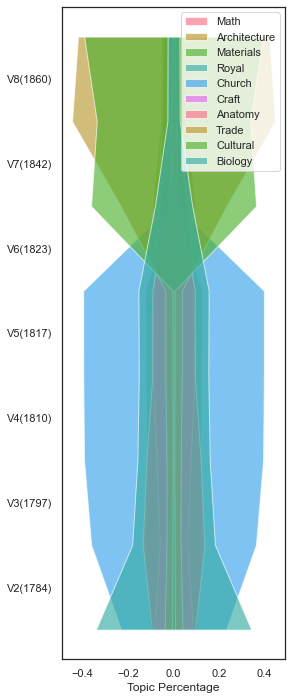

In [34]:
sns.set_theme(style="white",palette=sns.color_palette("husl"))

topic_labels=["Math","Architecture","Materials","Royal","Church","Craft","Anatomy","Trade","Cultural","Biology"]

df_topic_pct=df_version_topic.div(df_version_topic.sum(axis=1),axis=0)
plt.figure(figsize=(4,12))
plt.yticks([x+0.5 for x in range(8)],
           ['V1(1771)','V2(1784)','V3(1797)','V4(1810)','V5(1817)','V6(1823)','V7(1842)','V8(1860)'],
           rotation=0)

for i in range(10): # Entries changes for all topics
    plt.fill_betweenx(y=df_topic_pct.index,
                      x1=df_topic_pct.iloc[:,i],
                      x2=-1*df_topic_pct.iloc[:,i],
                      alpha=0.65,label=topic_labels[i])
    
plt.legend()
plt.xlabel("Topic Percentage",fontsize=12)

Text(0, 0.5, 'Topic Percentage')

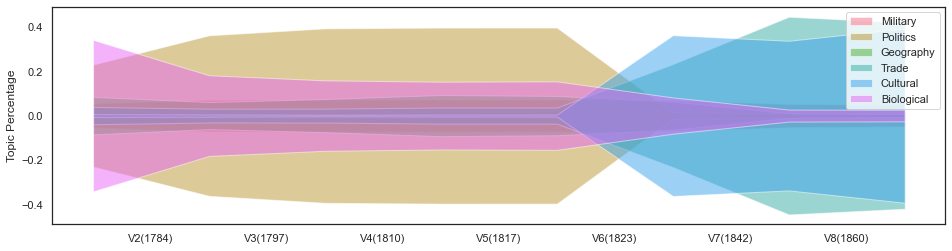

In [36]:
sns.set_theme(style="white",palette=sns.color_palette("husl"))

topic_labels=["Math","Spots","Chemical","Military","Politics","Geography","Agricultural","Trade","Cultural","Biological"]

df_topic_pct=df_version_topic.div(df_version_topic.sum(axis=1),axis=0)
plt.figure(figsize=(16,4))
plt.xticks([x+0.5 for x in range(8)],
           ['V1(1771)','V2(1784)','V3(1797)','V4(1810)','V5(1817)','V6(1823)','V7(1842)','V8(1860)'],
           rotation=0)

for i in [3,4,5,7,8,9]: 
    plt.fill_between(x=df_topic_pct.index,
                      y1=df_topic_pct.iloc[:,i],
                      y2=-1*df_topic_pct.iloc[:,i],
                      alpha=0.5,label=topic_labels[i])
    
plt.legend()
plt.ylabel("Topic Percentage",fontsize=12)

Text(0, 0.5, 'Topic Percentage')

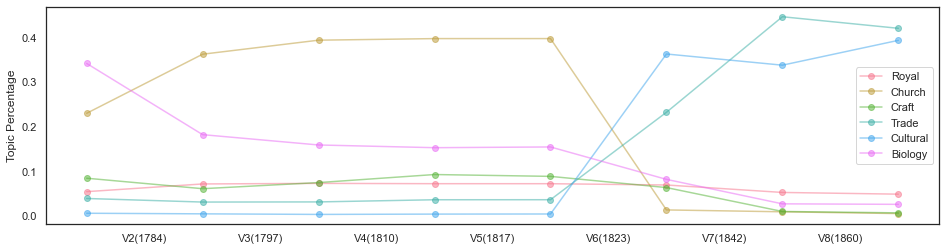

In [37]:
sns.set_theme(style="white",palette=sns.color_palette("husl"))

topic_labels=["Math","Architecture","Materials","Royal","Church","Craft","Anatomy","Trade","Cultural","Biology"]

df_topic_pct=df_version_topic.div(df_version_topic.sum(axis=1),axis=0)
plt.figure(figsize=(16,4))
plt.xticks([x+0.5 for x in range(8)],
           ['V1(1771)','V2(1784)','V3(1797)','V4(1810)','V5(1817)','V6(1823)','V7(1842)','V8(1860)'],
           rotation=0)

for i in [3,4,5,7,8,9]: # Materials science, Military & Royal Family, Politics & Church, Anatomy, Trade, Cultural
    plt.plot(df_topic_pct.index,
             df_topic_pct.iloc[:,i],marker="o",
             alpha=0.5,label=topic_labels[i])
    
plt.legend()
plt.ylabel("Topic Percentage",fontsize=12)

Text(0, 0.5, 'Topic Percentage')

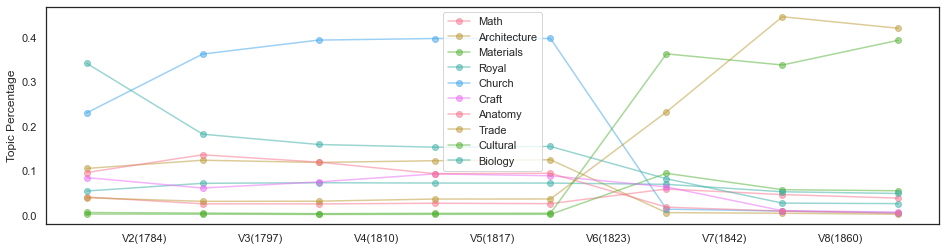

In [38]:
sns.set_theme(style="white",palette=sns.color_palette("husl"))

topic_labels=["Math","Architecture","Materials","Royal","Church","Craft","Anatomy","Trade","Cultural","Biology"]

df_topic_pct=df_version_topic.div(df_version_topic.sum(axis=1),axis=0)
plt.figure(figsize=(16,4))
plt.xticks([x+0.5 for x in range(8)],
           ['V1(1771)','V2(1784)','V3(1797)','V4(1810)','V5(1817)','V6(1823)','V7(1842)','V8(1860)'],
           rotation=0)

for i in range(10): # Trends of all topics in the eight editions
    plt.plot(df_topic_pct.index,
             df_topic_pct.iloc[:,i],marker="o",
             alpha=0.5,label=topic_labels[i])
    
plt.legend()
plt.ylabel("Topic Percentage",fontsize=12)

Text(0, 0.5, 'Topic Percentage')

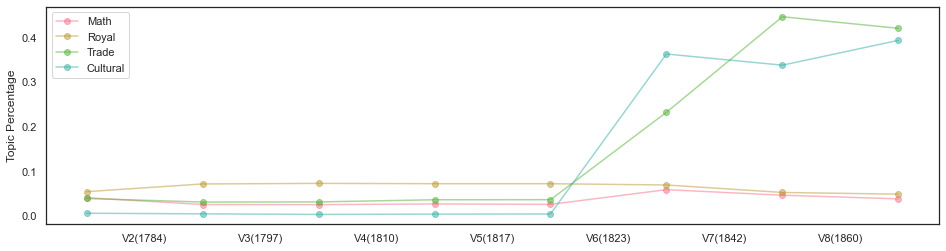

In [39]:
sns.set_theme(style="white",palette=sns.color_palette("husl"))

topic_labels=["Math","Architecture","Materials","Royal","Church","Craft","Anatomy","Trade","Cultural","Biology"]

df_topic_pct=df_version_topic.div(df_version_topic.sum(axis=1),axis=0)
plt.figure(figsize=(16,4))
plt.xticks([x+0.5 for x in range(8)],
           ['V1(1771)','V2(1784)','V3(1797)','V4(1810)','V5(1817)','V6(1823)','V7(1842)','V8(1860)'],
           rotation=0)

for i in [0,3,7,8]: # 
    plt.plot(df_topic_pct.index,
             df_topic_pct.iloc[:,i],marker="o",
             alpha=0.5,label=topic_labels[i])
    
plt.legend()
plt.ylabel("Topic Percentage",fontsize=12)

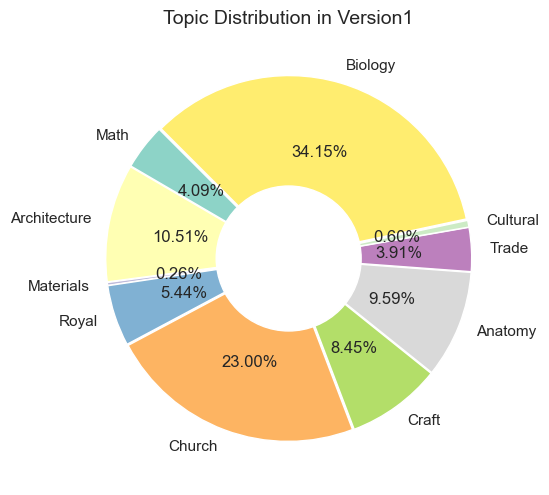

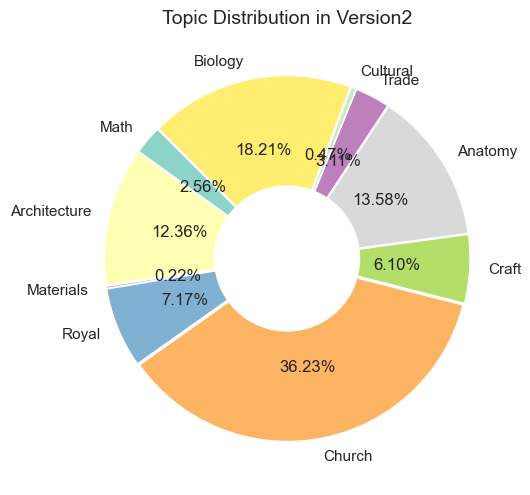

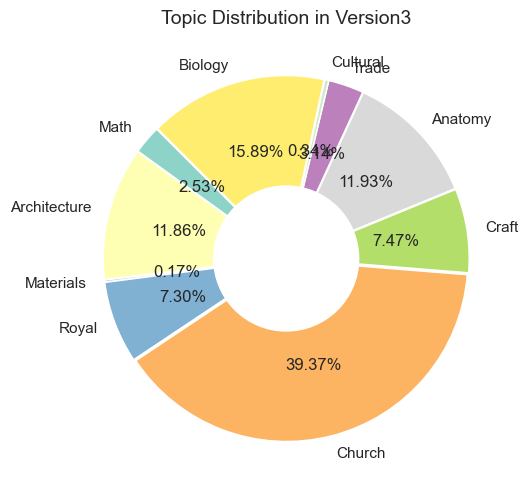

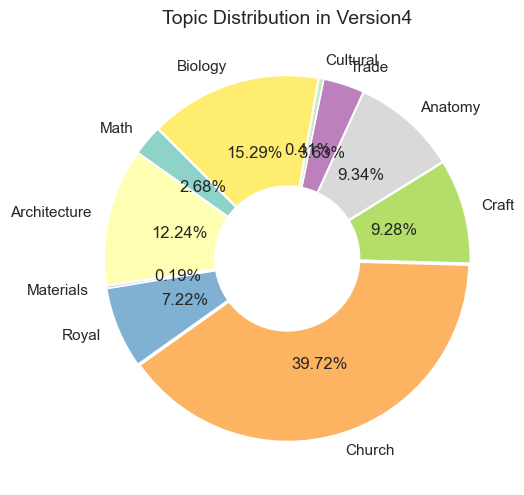

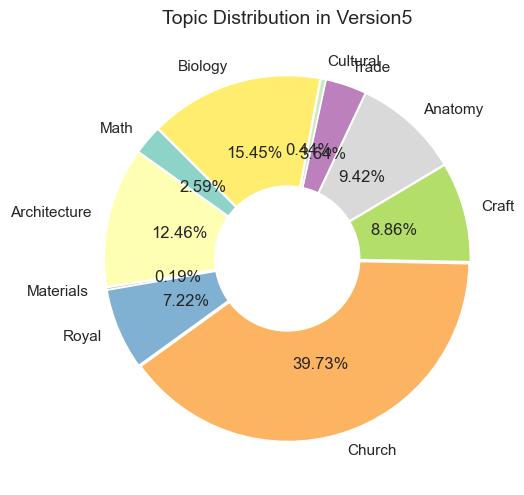

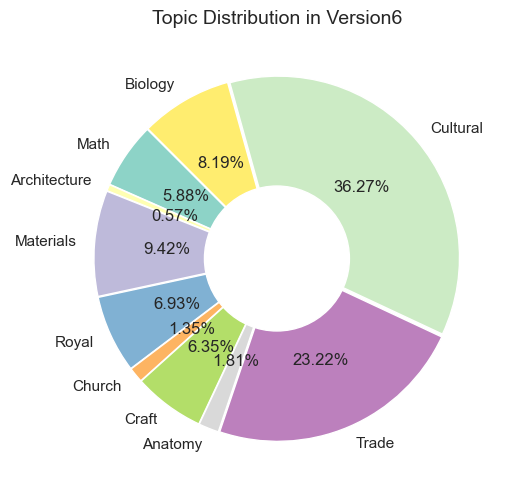

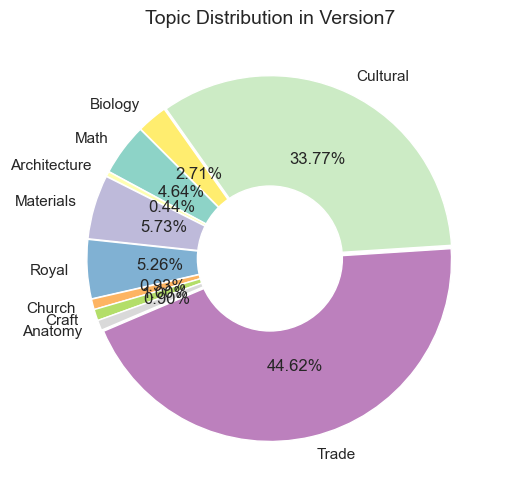

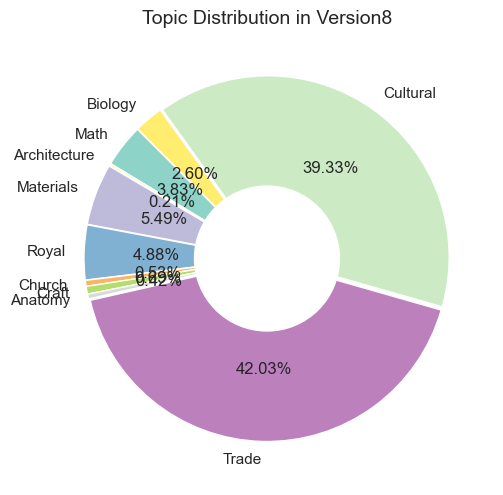

In [40]:
sns.set_theme(style="darkgrid",palette=sns.color_palette("Set2"))

# The distribution chart of each version's entries and the proportion of topics

topic_labels=["Math","Architecture","Materials","Royal","Church","Craft","Anatomy","Trade","Cultural","Biology"]
    
for i in range(df_version_topic.shape[0]):
    y_dist=df_version_topic.iloc[i,:]
    plt.figure(figsize=(8,6),dpi=100)
    
    plt.pie(x=y_dist.values,labels =topic_labels,autopct='%0.2f%%'
            ,startangle=135
            ,explode=[0.01]*10
            ,colors=plt.cm.Set3(np.linspace(0, 1, 10)))

    circle=plt.Circle((0,0), 0.4, color='white')
    p=plt.gcf()
    p.gca().add_artist(circle)

    #plt.legend(loc="upper right")
    plt.title("Topic Distribution in Version{}".format(i+1),fontsize=14)

    plt.show()
    print("="*120)